# 批量规范化 BN

加速深层网络收敛速度。结合7.6中的残差块，批量规范化使研究人员能够训练100层以上的网络

## 1. 训练深层网络
- 靠近数据层（底部层）收敛较慢，靠近输出层（顶部层）收敛较快
- 底部层一变化，所有层都会跟着变
- 会导致顶部层可能需要重新学习多次
- 导致收敛变慢

**提出问题：**
我们可以在学习底部层的时候避免变化顶部层

解决方法：提出批量归一化的概念：https://zh.d2l.ai/chapter_convolutional-modern/batch-norm.html


## 2. 批量归一化
固定在小批量里面的均值和方差：
$$\mu_B = \frac{1}{|B|} \sum_{i \in B} x_i \quad \text{and} \quad \sigma^2_B = \frac{1}{|B|} \sum_{i \in B} (x_i - \mu_B)^2 + \epsilon
$$
然后再做额外的调整（可学习的参数: 方差：$\gamma$，均值：$\beta$）
$$x_{i+1} = \gamma \frac{x_i - \mu_{B} }{\sigma_B} + \beta$$

- 可学习的参数为$\gamma$和$\beta$
- 作用在
  - 在全连接和卷积层输出上，激活函数前
  - 全连接层和卷积层输入上
- 对全连接层，作用在特征维
- 对于卷积层，作用在通道维


**2.1 全连接层：**
通常，我们将批量规范化层至于全连接层中仿射变换和激活函数之间。设全连接层的输入为$\bf{x}$，权重参数和偏置参数分别为$\bf{W}$和$\bf{b}$，激活函数为$\phi$，批量规范化的运算符为$\bf{BN}$。那么使用批量规范化的全连接层的输出计算详情如下：
$$\bf{h} = \phi(\bf{BN({Wx+b})})$$
回想一下，均值和方差是在应用变换的“相同”小批量上计算的

**2.2 卷积层：**
对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量规范化。当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。假设我们的小批量包含$m$个样本，并且对每个通道，卷积的输出具有高度$p$和宽度$q$。那么对于卷积层，我们的每个输出通道的$m\dot p\dot q$个元素上同时执行每个批量规范化。因此，在计算平均值和方差时，我们会手机所有空间位置的值，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行规范化。

**2.3 批量归一化在做什么**
- 最初论文是想用它来减少内部协变量转移
- 后续有论文指出它可能就是通过在每个小批量中加入噪声以控制模型复杂度$x_{i+1} = \gamma \frac{x_i - \mu_{B} }{\sigma_B} + \beta$
- 因此没有必要和dropout混合使用


## 3. 实现

In [12]:
'''从头开始实现一个具有张量的批量规范化层'''
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果在预测模型下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim = 0)
            var = ((X-mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上(axis=1)的均值和方差
            # 使用我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X-mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X-mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [13]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 4. 使用BN的LeNet
为了更好理解如何应用BatchNorm，下面我们将其应用于LeNet模型

In [14]:
net = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), BatchNorm(num_features=6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), BatchNorm(num_features=16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(in_features=16 * 4 * 4, out_features=120), BatchNorm(num_features=120, num_dims=2), nn.Sigmoid(),
    nn.Linear(in_features=120, out_features=84), BatchNorm(num_features=84, num_dims=2), nn.Sigmoid(),
    nn.Linear(in_features=84, out_features=10)
)

loss 0.264, train acc 0.903, test acc 0.847
17394.9 examples/sec on mps


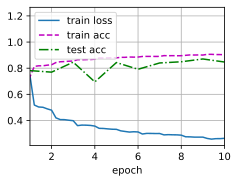

In [15]:
'''在Fashion-MNIST数据集上训练网络。与6.6中LeNet的主要区别在于学习率大很多'''
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
d2l.train_ch6(net, train_iter=train_iter, test_iter=test_iter, num_epochs=num_epochs, lr=lr, device=torch.device("mps"))

In [16]:
'''查看从第一毗连规范化层中学到的拉伸参数gamma和偏移参数beta'''
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.0567, 3.0916, 2.6503, 2.3057, 4.2374, 0.5450], device='mps:0',
        grad_fn=<ViewBackward0>),
 tensor([ 3.2835,  0.8737, -1.5968, -2.7292, -2.5402,  0.4488], device='mps:0',
        grad_fn=<ViewBackward0>))

## 5. 简明实现
使用深度学习框架中定义的BtachNorm。代码看起来和上面写的代码相同

loss 0.260, train acc 0.904, test acc 0.890
27475.6 examples/sec on mps


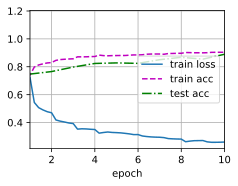

In [20]:
'''简明实现'''
net = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), nn.BatchNorm2d(num_features=6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.BatchNorm2d(num_features=16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(in_features=256, out_features=120), nn.BatchNorm1d(num_features=120), nn.Sigmoid(),
    nn.Linear(in_features=120, out_features=84), nn.BatchNorm1d(num_features=84), nn.Sigmoid(),
    nn.Linear(in_features=84, out_features=10)
)

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, torch.device("mps"))

## 6. 总结
- 批量归一化固定小批量中的均值和方差，然后学习出适合偏移和缩放
- 可以加速收敛速度，但是一般不改变模型精度